## memo
* validでのaccuracyを計算　実装する
* 特徴量の作り方。どんな特徴量があるか？調べる
* 時系列データでのCVのやり方
* lightgbm のbinaryのmetric　違い

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import japanize_matplotlib
%matplotlib inline

from sklearn.model_selection import TimeSeriesSplit# 時系列データでCVをきる
from sklearn.metrics import accuracy_score# accuracy scoreを計算
import lightgbm as gbm

import scipy.stats as stats# 多数決あんさんぼー
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)


In [3]:
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')
df_train

,Date,Open,High,Low,Close,Up
0,2004-01-02,50.85,50.91,50.62,50.72,1
1,2004-01-05,50.75,50.84,50.61,50.79,1
2,2004-01-06,50.87,51.26,50.86,51.15,1
3,2004-01-07,51.45,51.54,51.29,51.51,0
4,2004-01-08,51.15,51.33,51.02,51.28,0
...,...,...,...,...,...,...
2021,2012-01-11,108.62,109.00,108.41,108.86,1
2022,2012-01-12,109.68,109.90,109.44,109.83,0
2023,2012-01-13,109.53,109.72,109.08,109.66,1
2024,2012-01-17,109.99,110.47,109.57,109.96,1


### 予測する対象のデータにflg = 1を建てる 

In [4]:
df_test['pred_flg'] = 0
df_test['pred_flg'][5::6] = 1 
df_test.head(30)

<ipython-input-4-edad14ac1d73>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['pred_flg'][5::6] = 1


,Date,Open,High,Low,Close,pred_flg
0,2012-01-19,110.79,110.82,109.96,110.39,0
1,2012-01-20,110.45,111.10,110.36,110.73,0
2,2012-01-23,110.95,111.10,109.65,110.36,0
3,2012-01-24,110.16,110.16,108.13,108.39,0
4,2012-01-25,106.25,107.11,105.97,106.89,0
5,2012-01-26,109.03,109.16,108.37,108.75,1
6,2012-02-02,108.02,108.45,108.02,108.30,0
7,2012-02-03,108.75,109.60,108.64,109.40,0
8,2012-02-06,110.10,110.13,109.62,109.73,0
9,2012-02-07,109.05,110.30,109.04,110.09,0


In [5]:
df_train.head(20)

,Date,Open,High,Low,Close,Up
0,2004-01-02,50.85,50.91,50.62,50.72,1
1,2004-01-05,50.75,50.84,50.61,50.79,1
2,2004-01-06,50.87,51.26,50.86,51.15,1
3,2004-01-07,51.45,51.54,51.29,51.51,0
4,2004-01-08,51.15,51.33,51.02,51.28,0
5,2004-01-09,51.11,51.32,51.01,51.01,0
6,2004-01-12,50.80,50.90,50.55,50.87,0
7,2004-01-13,50.90,50.98,50.53,50.61,1
8,2004-01-14,50.43,50.65,50.40,50.64,1
9,2004-01-15,51.01,51.27,50.70,51.01,1


# ECA

<AxesSubplot:xlabel='Close', ylabel='Count'>

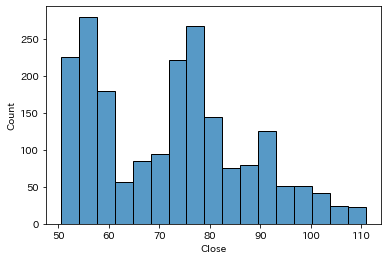

In [6]:
sns.histplot(df_train['Close'])

<AxesSubplot:xlabel='Close', ylabel='Count'>

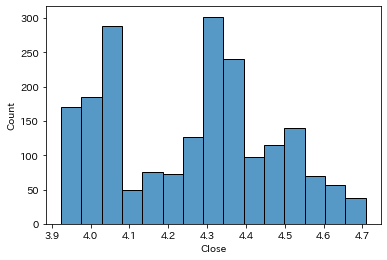

In [7]:
sns.histplot(np.log(df_train['Close']))

<AxesSubplot:xlabel='Close', ylabel='Count'>

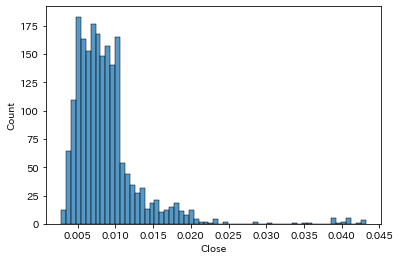

In [8]:
sns.histplot(np.log(df_train['Close']).diff().rolling(20).std())

In [9]:
feats = df_train.copy()

# 終値のみに絞る
feats= df_train[['Close']].copy()

# 終わり値の1営業日リターン
feats['return_1days'] = feats['Close'].pct_change(1)
# 終わり値の1営業日リターン
feats['return_2days'] = feats['Close'].pct_change(2)
# 終わり値の1営業日リターン
feats['return_3days'] = feats['Close'].pct_change(3)
# 終わり値の1営業日リターン
feats['return_4days'] = feats['Close'].pct_change(4)
# 終わり値の1営業日リターン
feats['return_5days'] = feats['Close'].pct_change(5)
# 終わり値の6営業日リターン
feats['return_6days'] = feats['Close'].pct_change(6)

# 終値の1営業日ボラティリティ
feats['volatility_1days'] = np.log(feats['Close']).diff().rolling(1).std()
# 終値の2営業日ボラティリティ
feats['volatility_2days'] = np.log(feats['Close']).diff().rolling(2).std()
# 終値の3営業日ボラティリティ
feats['volatility_3days'] = np.log(feats['Close']).diff().rolling(3).std()
# 終値の4営業日ボラティリティ
feats['volatility_4days'] = np.log(feats['Close']).diff().rolling(4).std()
# 終値の5営業日ボラティリティ
feats['volatility_5days'] = np.log(feats['Close']).diff().rolling(5).std()
# 終値の6営業日ボラティリティ
feats['volatility_6days'] = np.log(feats['Close']).diff().rolling(6).std()


# 終値の1営業日の単純移動平均線の剥離
feats['MA_gap_1days'] = feats['Close'] / (feats['Close'].rolling(1).mean())
# 終値の2営業日の単純移動平均線の剥離
feats['MA_gap_2days'] = feats['Close'] / (feats['Close'].rolling(2).mean())
# 終値の3営業日の単純移動平均線の剥離
feats['MA_gap_3days'] = feats['Close'] / (feats['Close'].rolling(3).mean())
# 終値の4営業日の単純移動平均線の剥離
feats['MA_gap_4days'] = feats['Close'] / (feats['Close'].rolling(4).mean())
# 終値の5営業日の単純移動平均線の剥離
feats['MA_gap_5days'] = feats['Close'] / (feats['Close'].rolling(5).mean())
# 終値の6営業日の単純移動平均線の剥離
feats['MA_gap_6days'] = feats['Close'] / (feats['Close'].rolling(6).mean())

# 欠損値処理
feats = feats.fillna(0)
# 元データのカラムを削除
feats = feats.drop(['Close'],axis = 1)

feats.head(8)

,return_1days,return_2days,return_3days,return_4days,return_5days,return_6days,volatility_1days,volatility_2days,volatility_3days,volatility_4days,volatility_5days,volatility_6days,MA_gap_1days,MA_gap_2days,MA_gap_3days,MA_gap_4days,MA_gap_5days,MA_gap_6days
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.001380,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,1.000690,0.000000,0.000000,0.000000,0.000000
2,0.007088,0.008478,0.000000,0.000000,0.000000,0.000000,0.0,0.004019,0.000000,0.000000,0.000000,0.000000,1.0,1.003531,1.005175,0.000000,0.000000,0.000000
3,0.007038,0.014176,0.015576,0.000000,0.000000,0.000000,0.0,0.000035,0.003267,0.000000,0.000000,0.000000,1.0,1.003507,1.007038,1.009159,0.000000,0.000000
4,-0.004465,0.002542,0.009648,0.011041,0.000000,0.000000,0.0,0.008124,0.006647,0.005503,0.000000,0.000000,1.0,0.997762,0.999350,1.001905,1.003719,0.000000
5,-0.005265,-0.009707,-0.002737,0.004332,0.005718,0.000000,0.0,0.000568,0.006877,0.006887,0.005966,0.000000,1.0,0.997360,0.994993,0.995560,0.997302,0.998695
6,-0.002745,-0.007995,-0.012425,-0.005474,0.001575,0.002957,0.0,0.001790,0.001293,0.005689,0.006205,0.005567,1.0,0.998626,0.996409,0.994186,0.994254,0.995467
7,-0.005111,-0.007842,-0.013066,-0.017472,-0.010557,-0.003544,0.0,0.001680,0.001419,0.001159,0.005205,0.005978,1.0,0.997438,0.995672,0.993473,0.991264,0.990960


In [10]:
df_train.iloc[1590:1620]

,Date,Open,High,Low,Close,Up
1590,2010-04-28,86.22,86.42,85.66,86.11,1
1591,2010-04-29,86.44,87.31,86.44,87.17,0
1592,2010-04-30,87.19,87.33,86.30,86.46,0
1593,2010-05-03,85.91,86.66,85.73,86.33,1
1594,2010-05-04,86.89,87.01,86.23,86.50,0
1595,2010-05-05,85.92,86.43,85.71,86.12,0
1596,2010-05-06,86.34,87.15,84.03,85.54,0
1597,2010-05-07,85.21,85.44,83.96,84.42,1
1598,2010-05-10,85.18,85.94,84.93,85.57,1
1599,2010-05-11,86.14,86.86,86.10,86.38,1


In [11]:
df_train

,Date,Open,High,Low,Close,Up
0,2004-01-02,50.85,50.91,50.62,50.72,1
1,2004-01-05,50.75,50.84,50.61,50.79,1
2,2004-01-06,50.87,51.26,50.86,51.15,1
3,2004-01-07,51.45,51.54,51.29,51.51,0
4,2004-01-08,51.15,51.33,51.02,51.28,0
...,...,...,...,...,...,...
2021,2012-01-11,108.62,109.00,108.41,108.86,1
2022,2012-01-12,109.68,109.90,109.44,109.83,0
2023,2012-01-13,109.53,109.72,109.08,109.66,1
2024,2012-01-17,109.99,110.47,109.57,109.96,1


In [12]:
df_test

,Date,Open,High,Low,Close,pred_flg
0,2012-01-19,110.79,110.82,109.96,110.39,0
1,2012-01-20,110.45,111.10,110.36,110.73,0
2,2012-01-23,110.95,111.10,109.65,110.36,0
3,2012-01-24,110.16,110.16,108.13,108.39,0
4,2012-01-25,106.25,107.11,105.97,106.89,0
...,...,...,...,...,...,...
1195,2019-12-17,185.52,186.40,184.62,184.68,0
1196,2019-12-18,183.86,184.01,182.38,183.10,0
1197,2019-12-19,183.83,185.17,183.66,185.08,0
1198,2019-12-20,186.29,186.64,184.81,185.19,0


In [13]:
feats = pd.concat([df_train[['Date','Up']],feats],axis = 1)
feats.head()

,Date,Up,return_1days,return_2days,return_3days,return_4days,return_5days,return_6days,volatility_1days,volatility_2days,volatility_3days,volatility_4days,volatility_5days,volatility_6days,MA_gap_1days,MA_gap_2days,MA_gap_3days,MA_gap_4days,MA_gap_5days,MA_gap_6days
0,2004-01-02,1,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,1.0,0.000000,0.000000,0.000000,0.000000,0.0
1,2004-01-05,1,0.001380,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,1.0,1.000690,0.000000,0.000000,0.000000,0.0
2,2004-01-06,1,0.007088,0.008478,0.000000,0.000000,0.0,0.0,0.0,0.004019,0.000000,0.000000,0.0,0.0,1.0,1.003531,1.005175,0.000000,0.000000,0.0
3,2004-01-07,0,0.007038,0.014176,0.015576,0.000000,0.0,0.0,0.0,0.000035,0.003267,0.000000,0.0,0.0,1.0,1.003507,1.007038,1.009159,0.000000,0.0
4,2004-01-08,0,-0.004465,0.002542,0.009648,0.011041,0.0,0.0,0.0,0.008124,0.006647,0.005503,0.0,0.0,1.0,0.997762,0.999350,1.001905,1.003719,0.0


In [14]:
#feats.set_index('Date',inplace = True)
#feats

## 5-fold CVで学習
memo: $Accuracy = \frac{TP+TN}{TP+FP+TN+FN} = \frac{正解した行数の合計}{全データ（行数）合計}$

In [15]:
#train_end = '2010-05-28'
#val_start = '2010-06-09'
#val_end = '2012-01-12'
#test_start = '2012-01-19'
#test_end = '2019-12-23'

In [16]:
# folds = TimeSeriesSplit(n_splits = 5)
# (train_index,valid_index) = next(iter(folds.split(feats)))

# fig, axes = plt.subplots(2,1)
# sns.lineplot(data = feats, x = 'Date', y = 'return_1days',ax = axes[0],label = 'original')
# plt.show()

In [17]:
# folds = TimeSeriesSplit(n_splits = 5)

# fix,axes = plt.subplots(5,1)

# for i,(train_index, valid_index) in enumerate(folds.split(feats)):
#     #　特徴量return_6days,volatility_6daysが未来の六日間の情報。リークしないように、test_indexは頭３個のindexは削除する
#     valid_index = valid_index[6:]
    
#     feats_train = feats.iloc[train_index].copy()
#     feats_valid = feats.iloc[valid_index].copy()
    
#     sns.lineplot(data = feats, x = 'Date', y = 'return_1days',label = 'original')
#     sns.lineplot(data = feats_train, x = 'Date', y = 'return_1days', label = 'train')
#     sns.lineplot(data = feats_valid, x = 'Date', y = 'return_1days', label = 'valid')

# plt.legend()
# plt.show()

In [18]:
feats_X = feats.reset_index().loc[:,'return_1days':]
feats_y = feats.reset_index().loc[:,'Up']
date = feats.reset_index().loc[:,'Date']

In [21]:
folds = TimeSeriesSplit(n_splits = 5)
    
# light gbm のパラメータ
params = {
    'boosting_type' : 'gbdt',
    'objective' : 'binary',
    'metric' : 'binary_logloss',
    'max_depth' : 9,
        }

train_score =[]
valid_score =[]
models =[]
for i,(train_index, valid_index) in enumerate(folds.split(feats)):
    #　特徴量return_6days,volatility_6daysが未来の六日間の情報。リークしないように、test_indexは頭３個のindexは削除する
    valid_index = valid_index[6:]

    X_train, X_valid = feats_X.iloc[train_index],feats_X.iloc[valid_index]
    y_train, y_valid = feats_y[train_index], feats_y[valid_index]
    
    train_data = gbm.Dataset(X_train, y_train)
    valid_data = gbm.Dataset(X_valid, y_valid,reference = train_data)
    
    print('-----------------------------')
    print('model No:',i)
    model = gbm.train(params,
                    train_data,
                    valid_sets = [train_data,valid_data],
                    num_boost_round = 10000,
                    early_stopping_rounds = 10,
                    verbose_eval = 50
                    )

    
    # モデル評価
    # trainのモデル評価
    train_pred_prob = model.predict(X_train)# arrayで返ってくる。値は確率
    train_pred = np.where(train_pred_prob < 0.5 ,0,1 )# ０、１に変換
    train_pred_vs_data_df = pd.concat([y_train,pd.Series(train_pred,index = train_index)],axis = 1)# 真値と予測値のｄｆ作成
    train_pred_vs_data_df.columns = ['true','pred']
    
    # validのモデル評価
    valid_pred_prob = model.predict(X_valid)
    valid_pred = np.where(valid_pred_prob < 0.5 , 0 ,1)
    valid_pred_vs_data_df = pd.concat([y_valid,pd.Series(valid_pred, index = valid_index)],axis = 1)
    valid_pred_vs_data_df.columns = ['true','pred']
    
    train_score.append(accuracy_score(train_pred_vs_data_df['true'],train_pred_vs_data_df['pred']))
    valid_score.append(accuracy_score(valid_pred_vs_data_df['true'],valid_pred_vs_data_df['pred']))
    
    models.append(model)
    


-----------------------------
model No: 0
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 165, number of negative: 176
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.061742 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1806
[LightGBM] [Info] Number of data points in the train set: 341, number of used features: 16
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.483871 -> initscore=-0.064539
[LightGBM] [Info] Start training from score -0.064539
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Tr

In [22]:
train_score

[0.8152492668621701,
 0.7610619469026548,
 0.7320197044334975,
 0.7514792899408284,
 0.7779751332149201]

In [23]:
valid_score

[0.5377643504531722,
 0.4984894259818731,
 0.540785498489426,
 0.5649546827794562,
 0.56797583081571]

# testデータで予測

In [24]:
feats_test = df_test.copy()

# 終値のみに絞る
feats_test= df_test[['Close']].copy()

# 終わり値の1営業日リターン
feats_test['return_1days'] = feats_test['Close'].pct_change(1)
# 終わり値の1営業日リターン
feats_test['return_2days'] = feats_test['Close'].pct_change(2)
# 終わり値の1営業日リターン
feats_test['return_3days'] = feats_test['Close'].pct_change(3)
# 終わり値の1営業日リターン
feats_test['return_4days'] = feats_test['Close'].pct_change(4)
# 終わり値の1営業日リターン
feats_test['return_5days'] = feats_test['Close'].pct_change(5)
# 終わり値の6営業日リターン
feats_test['return_6days'] = feats_test['Close'].pct_change(6)

# 終値の1営業日ボラティリティ
feats_test['volatility_1days'] = np.log(feats_test['Close']).diff().rolling(1).std()
# 終値の2営業日ボラティリティ
feats_test['volatility_2days'] = np.log(feats_test['Close']).diff().rolling(2).std()
# 終値の3営業日ボラティリティ
feats_test['volatility_3days'] = np.log(feats_test['Close']).diff().rolling(3).std()
# 終値の4営業日ボラティリティ
feats_test['volatility_4days'] = np.log(feats_test['Close']).diff().rolling(4).std()
# 終値の5営業日ボラティリティ
feats_test['volatility_5days'] = np.log(feats_test['Close']).diff().rolling(5).std()
# 終値の6営業日ボラティリティ
feats_test['volatility_6days'] = np.log(feats_test['Close']).diff().rolling(6).std()


# 終値の1営業日の単純移動平均線の剥離
feats_test['MA_gap_1days'] = feats_test['Close'] / (feats_test['Close'].rolling(1).mean())
# 終値の2営業日の単純移動平均線の剥離
feats_test['MA_gap_2days'] = feats_test['Close'] / (feats_test['Close'].rolling(2).mean())
# 終値の3営業日の単純移動平均線の剥離
feats_test['MA_gap_3days'] = feats_test['Close'] / (feats_test['Close'].rolling(3).mean())
# 終値の4営業日の単純移動平均線の剥離
feats_test['MA_gap_4days'] = feats_test['Close'] / (feats_test['Close'].rolling(4).mean())
# 終値の5営業日の単純移動平均線の剥離
feats_test['MA_gap_5days'] = feats_test['Close'] / (feats_test['Close'].rolling(5).mean())
# 終値の6営業日の単純移動平均線の剥離
feats_test['MA_gap_6days'] = feats_test['Close'] / (feats_test['Close'].rolling(6).mean())

# 欠損値処理
feats_test = feats_test.fillna(0)
# 元データのカラムを削除
feats_test = feats_test.drop(['Close'],axis = 1)

feats_test.head(8)

,return_1days,return_2days,return_3days,return_4days,return_5days,return_6days,volatility_1days,volatility_2days,volatility_3days,volatility_4days,volatility_5days,volatility_6days,MA_gap_1days,MA_gap_2days,MA_gap_3days,MA_gap_4days,MA_gap_5days,MA_gap_6days
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.003080,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,1.001538,0.000000,0.000000,0.000000,0.000000
2,-0.003341,-0.000272,0.000000,0.000000,0.000000,0.000000,0.0,0.004541,0.000000,0.000000,0.000000,0.000000,1.0,0.998326,0.998793,0.000000,0.000000,0.000000
3,-0.017851,-0.021132,-0.018118,0.000000,0.000000,0.000000,0.0,0.010370,0.010809,0.000000,0.000000,0.000000,1.0,0.990994,0.986919,0.985655,0.000000,0.000000
4,-0.013839,-0.031443,-0.034679,-0.031706,0.000000,0.000000,0.0,0.002882,0.007570,0.009657,0.000000,0.000000,1.0,0.993032,0.984738,0.979811,0.977486,0.000000
5,0.017401,0.003321,-0.014589,-0.017881,-0.014856,0.000000,0.0,0.022053,0.019291,0.015770,0.014072,0.000000,1.0,1.008625,1.006851,1.001404,0.997487,0.995408
6,-0.004138,0.013191,-0.000830,-0.018666,-0.021945,-0.018933,0.0,0.015131,0.015950,0.015755,0.013658,0.012595,1.0,0.997927,1.002964,1.002012,0.997807,0.994460
7,0.010157,0.005977,0.023482,0.009318,-0.008699,-0.012011,0.0,0.010078,0.010894,0.014019,0.015168,0.013583,1.0,1.005053,1.005361,1.009831,1.009728,1.006610


## アンサンブル

In [25]:
# 各モデルでの出力
preds = []
for model in models:
    test_pred_prob = model.predict(feats_test)
    test_pred = np.where(test_pred_prob < 0.5,0,1)
    preds.append(test_pred)

# 各モデルをstack
preds_concat = np.stack([preds[0],preds[1],preds[2],preds[3],preds[4]],axis = 0)
preds_concat

array([[1, 1, 1, ..., 1, 1, 0],
       [1, 1, 1, ..., 1, 0, 1],
       [1, 1, 1, ..., 1, 1, 0],
       [1, 1, 1, ..., 1, 0, 0],
       [1, 1, 1, ..., 1, 1, 0]])

In [26]:
# 各モデルの多数決（最頻値：mode）をとる
test_pred_ensamble_mode = stats.mode(preds_concat)# 最頻値とその個数を出力する

print('多数決の出力:',test_pred_ensamble_mode[0])
print('最頻値の数:',test_pred_ensamble_mode[1])

多数決の出力: [[1 1 1 ... 1 1 0]]
最頻値の数: [[5 5 5 ... 5 3 4]]


In [27]:
test_pred_df = pd.concat([df_test[['Date','pred_flg']],pd.Series(test_pred_ensamble_mode[0][0])],axis = 1)

test_pred = test_pred_df.loc[test_pred_df['pred_flg']==1][['Date',0]]

In [28]:
test_pred_df.head(99)

,Date,pred_flg,0
0,2012-01-19,0,1
1,2012-01-20,0,1
2,2012-01-23,0,1
3,2012-01-24,0,1
4,2012-01-25,0,1
5,2012-01-26,1,1
6,2012-02-02,0,0
7,2012-02-03,0,1
8,2012-02-06,0,1
9,2012-02-07,0,0


In [29]:
test_pred

,Date,0
5,2012-01-26,1
11,2012-02-09,0
17,2012-02-24,0
23,2012-03-09,1
29,2012-03-23,1
...,...,...
1175,2019-10-25,1
1181,2019-11-08,1
1187,2019-11-22,1
1193,2019-12-09,1


In [30]:
test_pred['Date'] = pd.to_datetime(test_pred['Date'])
test_pred

,Date,0
5,2012-01-26,1
11,2012-02-09,0
17,2012-02-24,0
23,2012-03-09,1
29,2012-03-23,1
...,...,...
1175,2019-10-25,1
1181,2019-11-08,1
1187,2019-11-22,1
1193,2019-12-09,1


In [54]:
test_pred.to_csv('submit.csv',index = False)

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

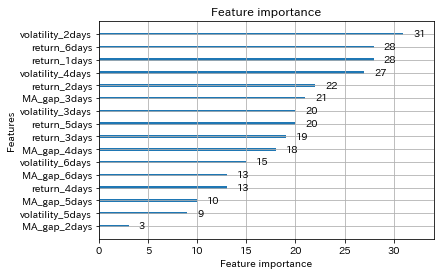

In [32]:
gbm.plot_importance(models[4])